In [49]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, roc_curve

In [50]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))
train_data = pd.read_csv('10_weekly_train.csv')
test_data = pd.read_csv('10_weekly_test.csv')

In [51]:
train_mov = train_data["movement"]
test_mov = test_data["movement"]
#col_name = train_data.drop(["movement"],1).columns
#train_data[col_name] = scaler.fit_transform(train_data.drop(["movement"],1))
#test_data[col_name] = scaler.fit_transform(test_data.drop(["movement"],1))
#train_data["movement"] = train_mov
#test_data["movement"] = test_mov

In [52]:
col_name = train_data.drop(["Close (t)","movement"],1).columns
train = train_data.copy()
test = test_data.copy()
train[col_name] = scaler_x.fit_transform(train_data.drop(["Close (t)","movement"],1))
label_train = pd.Series(scaler_y.fit_transform(train_data[["Close (t)"]]).reshape(-1))
test[col_name] = scaler_x.fit_transform(test_data.drop(["Close (t)","movement"],1))
scaled_test = pd.Series(scaler_test.fit_transform(test_data[["Close (t)"]]).reshape(-1))
label_test = test_data["Close (t)"]

In [53]:
def evaluate(test, label_test):
    predicted = test
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    cm = confusion_matrix(label_test, predicted)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
    classification = classification_report(label_test, predicted)
    print(classification)

Decision Tree

In [54]:
dtr = DecisionTreeRegressor()
DecisionTreeRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

DecisionTreeRegressor(ccp_alpha=0, max_depth=6)

In [55]:
dtr.fit(train, label_train)

score = dtr.score(train, label_train)
print("R-squared:", score) 

ypred = dtr.predict(test)
ypred = scaler_test.inverse_transform(ypred.reshape(-1,1))
ypred = ypred.reshape(-1)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 1.0
MSE:  33359.9543693891
RMSE:  16679.97718469455


In [56]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = dtr.predict(train)
ypred_train = scaler_y.inverse_transform(ypred_train.reshape(-1,1))
ypred_train = ypred_train.reshape(-1)
train_move = (ypred_train - train_data["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test_data["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]

accuracy: 0.6065573770491803
precision: 0.48055549981829654
recall: 0.6065573770491803
f1 0.47725166557325494
metrics.roc_auc_score 0.49396511079679395
              precision    recall  f1-score   support

           0       0.26      0.02      0.03       303
           1       0.61      0.97      0.75       490

    accuracy                           0.61       793
   macro avg       0.44      0.49      0.39       793
weighted avg       0.48      0.61      0.48       793



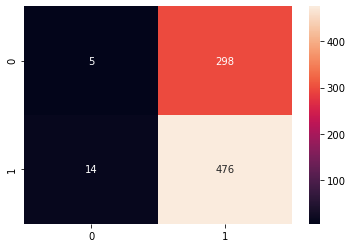

In [57]:
#metric_train = evaluate(train_move, label_train_move)
metric_test = evaluate(test_move, label_test_move)

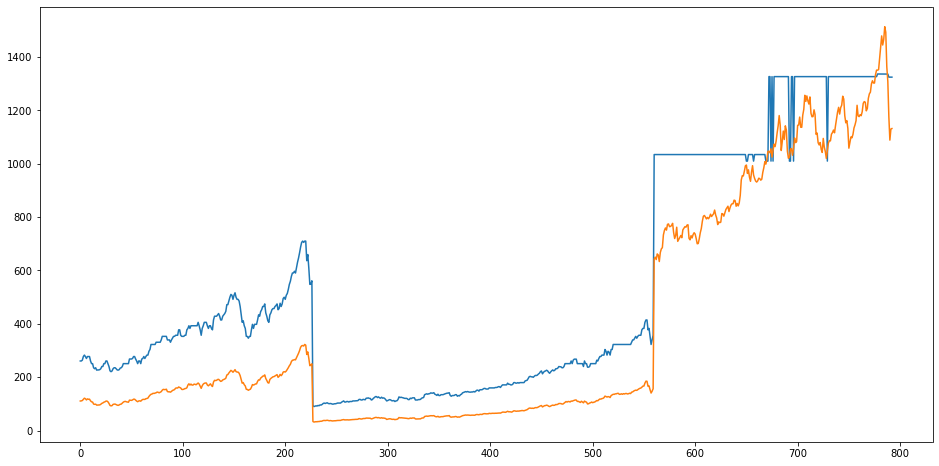

In [58]:
plt.figure(figsize=(16,8))
plt.plot(ypred)
plt.plot(label_test)

Gradient Boosting

In [59]:
gb = GradientBoostingRegressor()
GradientBoostingRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

GradientBoostingRegressor(ccp_alpha=0, criterion='mse', max_depth=6)

In [60]:
gb.fit(train, label_train)

score = gb.score(train, label_train)
print("R-squared:", score) 

ypred = gb.predict(test)
ypred = scaler_test.inverse_transform(ypred.reshape(-1,1))
ypred = ypred.reshape(-1)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.9999804594881484
MSE:  53593.96622544105
RMSE:  26796.983112720525


In [61]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = gb.predict(train)
ypred_train = scaler_y.inverse_transform(ypred_train.reshape(-1,1))
ypred_train = ypred_train.reshape(-1)
train_move = (ypred_train - train_data["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test_data["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]

accuracy: 0.6153846153846154
precision: 0.5413424603565449
recall: 0.6153846153846154
f1 0.4817584723170875
metrics.roc_auc_score 0.5011079679396512
              precision    recall  f1-score   support

           0       0.42      0.02      0.03       303
           1       0.62      0.99      0.76       490

    accuracy                           0.62       793
   macro avg       0.52      0.50      0.40       793
weighted avg       0.54      0.62      0.48       793



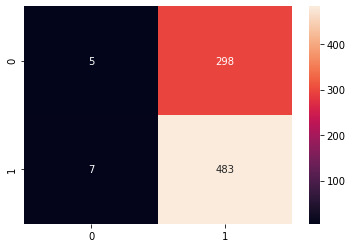

In [62]:
#metric_train = evaluate(train_move, label_train_move)
metric_test = evaluate(test_move, label_test_move)

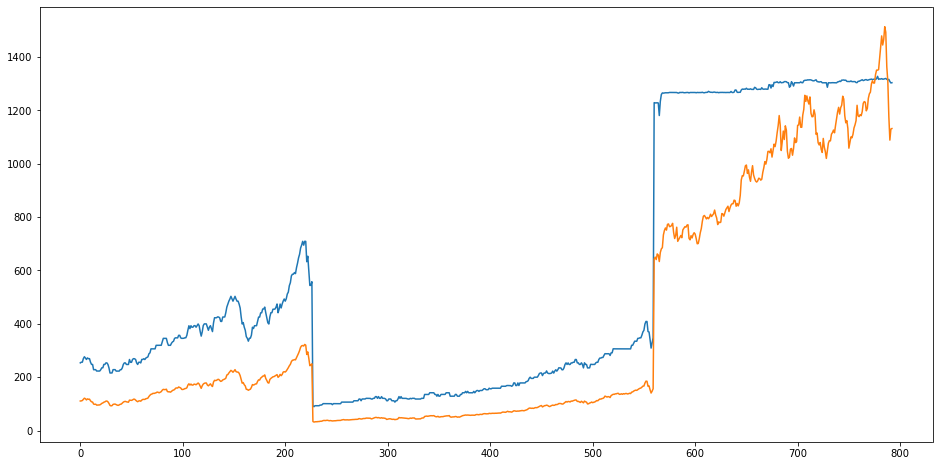

In [63]:
plt.figure(figsize=(16,8))
plt.plot(ypred)
plt.plot(label_test)

Random Forest

In [64]:
rfc = RandomForestRegressor()
RandomForestRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

RandomForestRegressor(ccp_alpha=0, max_depth=6)

In [65]:
rfc.fit(train, label_train)

score = rfc.score(train, label_train)
print("R-squared:", score) 

ypred = rfc.predict(test)
ypred = gb.predict(test)
ypred = scaler_test.inverse_transform(ypred.reshape(-1,1))
ypred = ypred.reshape(-1)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.9999772614596921
MSE:  53593.96622544105
RMSE:  26796.983112720525


In [66]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = rfc.predict(train)
ypred_train = scaler_y.inverse_transform(ypred_train.reshape(-1,1))
ypred_train = ypred_train.reshape(-1)
train_move = (ypred_train - train_data["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test_data["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]

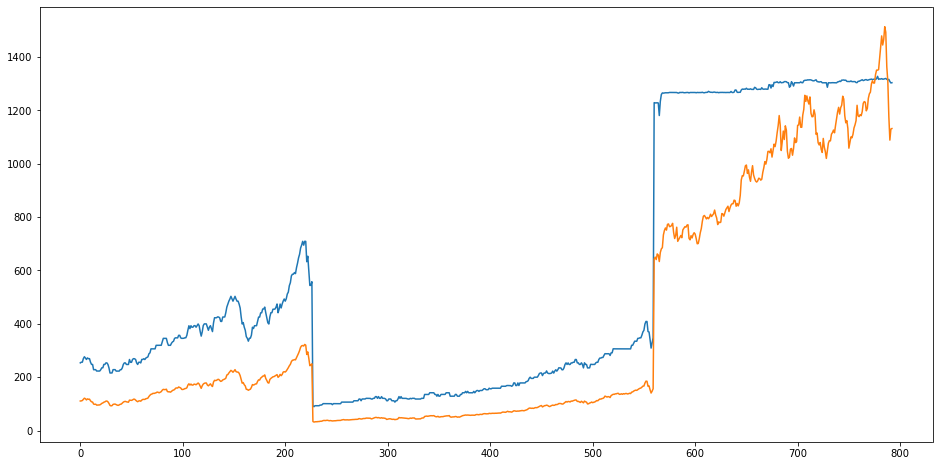

In [67]:
plt.figure(figsize=(16,8))
plt.plot(ypred)
plt.plot(label_test)

accuracy: 0.6153846153846154
precision: 0.5413424603565449
recall: 0.6153846153846154
f1 0.4817584723170875
metrics.roc_auc_score 0.5011079679396512
              precision    recall  f1-score   support

           0       0.42      0.02      0.03       303
           1       0.62      0.99      0.76       490

    accuracy                           0.62       793
   macro avg       0.52      0.50      0.40       793
weighted avg       0.54      0.62      0.48       793



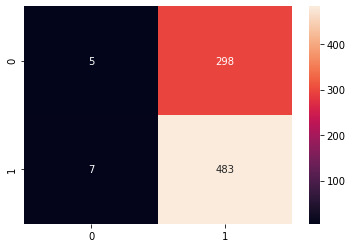

In [68]:
#metric_train = evaluate(train_move, label_train_move)
metric_test = evaluate(test_move, label_test_move)